In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc, precision_score, roc_auc_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# Experiments block
import wandb


pd.set_option('display.max_columns', None)

In [8]:
# Подготовим инфраструктуру для версионирования экспериментов
project_name = "Makarov_mfdp_unit_5"
exp_name = "exp_"
config = []

## Эксперимент 2 Feature Importance via permutation and sequent feature selection
Идея - выбрать отфильтрованные по пустоте и корреляции признаки, и вместо оценки feature Importance от катбуста, использовать 
https://scikit-learn.org/stable/modules/permutation_importance.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Возможно, важность по перестановкам более точно указывает на объективную важность, чем важность по этнтропии дерева (catboost)

In [3]:
train_corrs_removed = pd.read_csv("features_selected_without_boost_selection.csv")
train_corrs_removed = train_corrs_removed.drop(["Unnamed: 0"], axis=1)

Learning rate set to 0.297052
0:	total: 159ms	remaining: 15.8s
99:	total: 1.64s	remaining: 0us


Text(0.5, 0, 'Decrease in accuracy score')

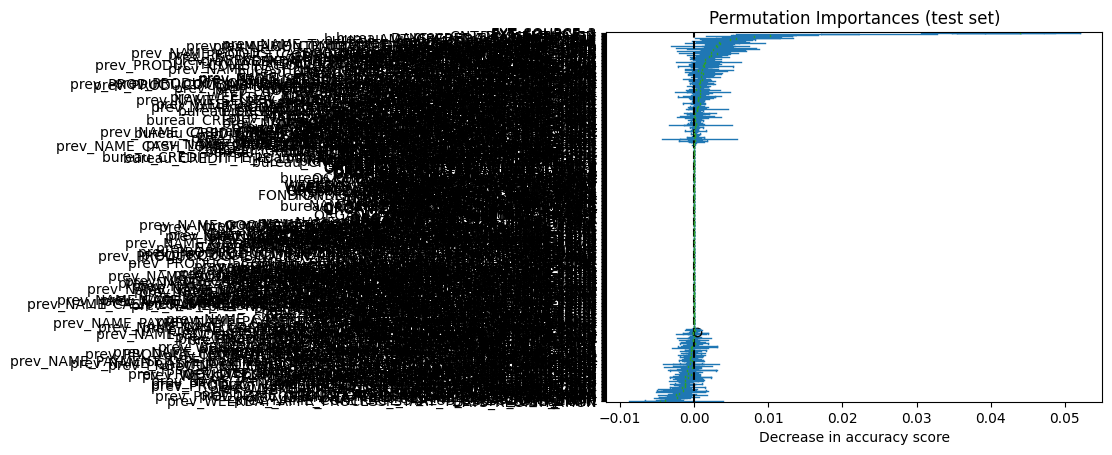

In [4]:
# Создадим классификатор для задачи

catboost_model = CatBoostClassifier(
    iterations=100,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42,
    #min_data_in_leaf=20
    
)

# Создадим отложенную валидацию
X = train_corrs_removed.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = train_corrs_removed["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# фитим алгоритм

catboost_model.fit(X_train, y_train)

# Посчитаем важность фич по перестановкам
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight

weights = compute_sample_weight(class_weight="balanced", y=y_test)

result = permutation_importance(
    catboost_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring="roc_auc", sample_weight = weights
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
#ax.figure.tight_layout()

Text(0.5, 0, 'Decrease in accuracy score')

<Figure size 1600x1000 with 0 Axes>

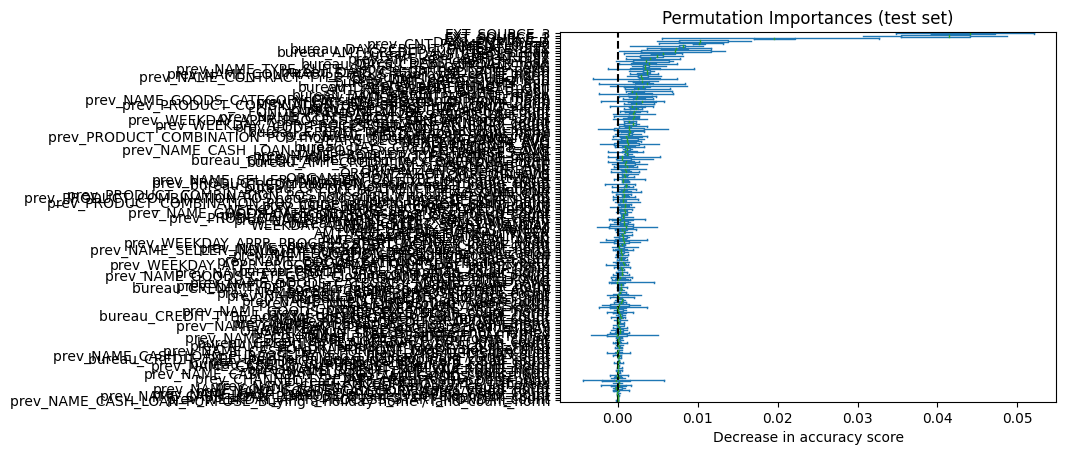

In [5]:
importances_filtered = importances.loc[:, (importances.sum() > 0)]
fig = plt.figure()
fig.set_size_inches(16, 10)
ax = importances_filtered.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
#ax.figure.tight_layout()

Learning rate set to 0.180666
0:	test: 0.6634093	best: 0.6634093 (0)	total: 11ms	remaining: 1.09s
99:	test: 0.7147674	best: 0.7245763 (45)	total: 973ms	remaining: 0us

bestTest = 0.7245762712
bestIteration = 45

Shrink model to first 46 iterations.


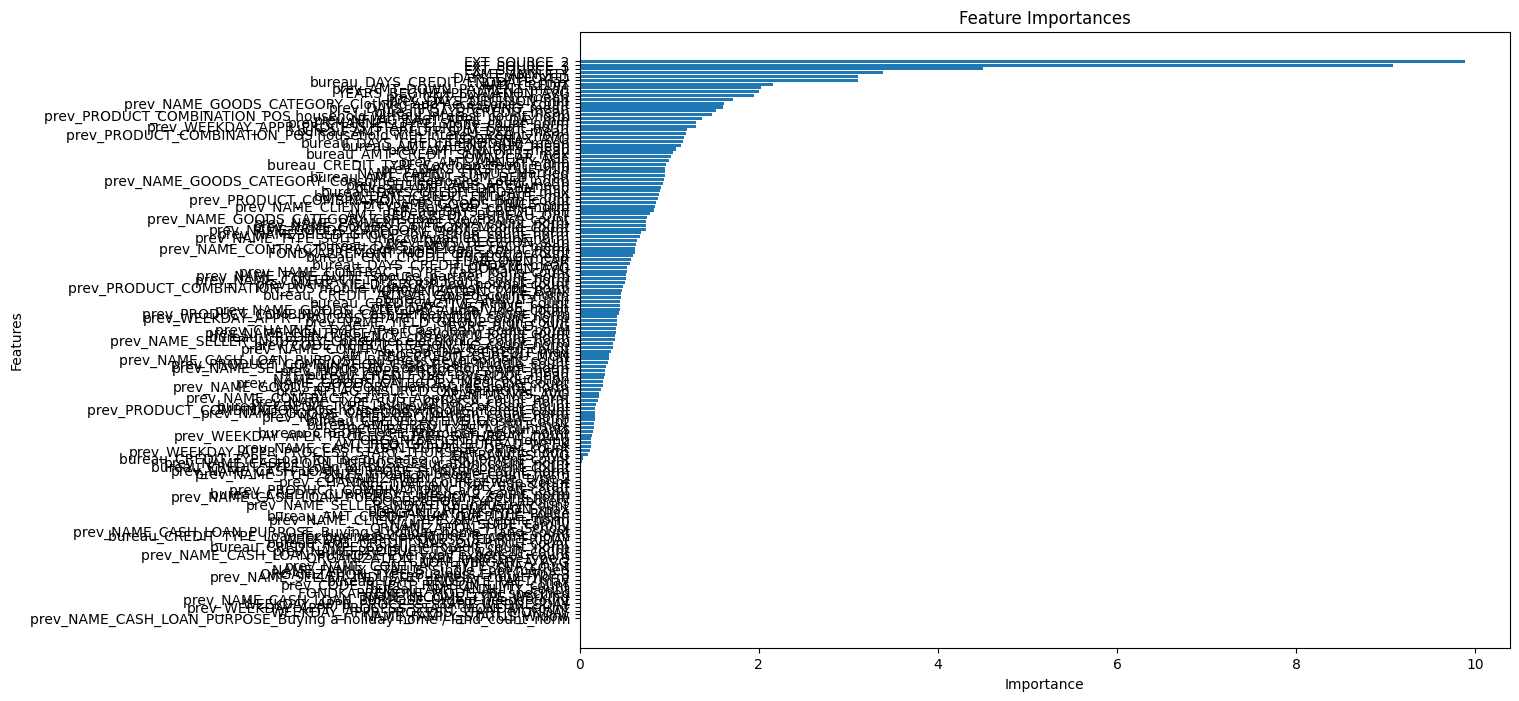

{'learn': {'Accuracy:use_weights=true': 0.9161311423292068,
  'Logloss': 0.33633271233303136,
  'Precision:use_weights=true': 0.8720921737392195,
  'F1:use_weights=true': 0.9208169947872609,
  'Recall:use_weights=true': 0.9753086419753086},
 'validation': {'NormalizedGini:use_weights=true': 0.4491525423728815,
  'Accuracy:use_weights=true': 0.6617797952173019,
  'Logloss': 0.616997428425721,
  'Precision:use_weights=true': 0.7283042921946771,
  'F1:use_weights=true': 0.6549717282505322,
  'Recall:use_weights=true': 0.6755725190839694,
  'AUC': 0.7245762711864407}}

In [6]:
# Замерим метрики на отобранных таким образом фичах (второй вариант)

X = train_corrs_removed[importances_filtered.columns]
y = train_corrs_removed["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)


# Установочный запуск + иницииализация параметров
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)


# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
catboost_model.get_best_score()

In [9]:
y_pred = catboost_model.predict_proba(X_test)[:, 1]

wandb.init(
        project=project_name, name=exp_name+"2"+"_persuation_auc_weighted"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y_test, y_pred=catboost_model.predict(X_test)),
        "f1_score_weighted": f1_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "precision_weighted": precision_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y_test, y_probas = catboost_model.predict_proba(X_test))
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

wandb: Currently logged in as: qeshtir (qesh-squad). Use `wandb login --relogin` to force relogin


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.73003
f1_score_weighted,0.80378
gini,0.44915
precision_weighted,0.9228
roc_auc_score,0.72458


#### Попробуем циклически избавиться от нулевых по важности фичей с помощью FI catboost

In [10]:
# Create a pandas dataframe for easier visualization
def create_importance_df(X_train, feature_importances):
    importance_df = pd.DataFrame({
        'Features': X_train.columns,
        'Importance': feature_importances
    })
    
    # Sort the dataframe based on the feature importances
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df

# Get feature importances
def get_feature_importances():
    feature_importances = catboost_model.get_feature_importance()
    importance_df = importance_df_dr

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Features'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

Learning rate set to 0.180666
0:	test: 0.6563143	best: 0.6563143 (0)	total: 8.72ms	remaining: 863ms
99:	test: 0.7087471	best: 0.7189772 (12)	total: 770ms	remaining: 0us

bestTest = 0.7189772286
bestIteration = 12

Shrink model to first 13 iterations.
Learning rate set to 0.180666
0:	test: 0.6555481	best: 0.6555481 (0)	total: 6.77ms	remaining: 670ms
99:	test: 0.7164801	best: 0.7180861 (95)	total: 679ms	remaining: 0us

bestTest = 0.7180861043
bestIteration = 95

Shrink model to first 96 iterations.
Learning rate set to 0.180666
0:	test: 0.6619982	best: 0.6619982 (0)	total: 20.7ms	remaining: 2.05s
99:	test: 0.6990620	best: 0.7172459 (41)	total: 686ms	remaining: 0us

bestTest = 0.7172459244
bestIteration = 41

Shrink model to first 42 iterations.
Learning rate set to 0.180666
0:	test: 0.6551248	best: 0.6551248 (0)	total: 12.4ms	remaining: 1.23s
99:	test: 0.7075681	best: 0.7242860 (64)	total: 680ms	remaining: 0us

bestTest = 0.7242859684
bestIteration = 64

Shrink model to first 65 iteratio

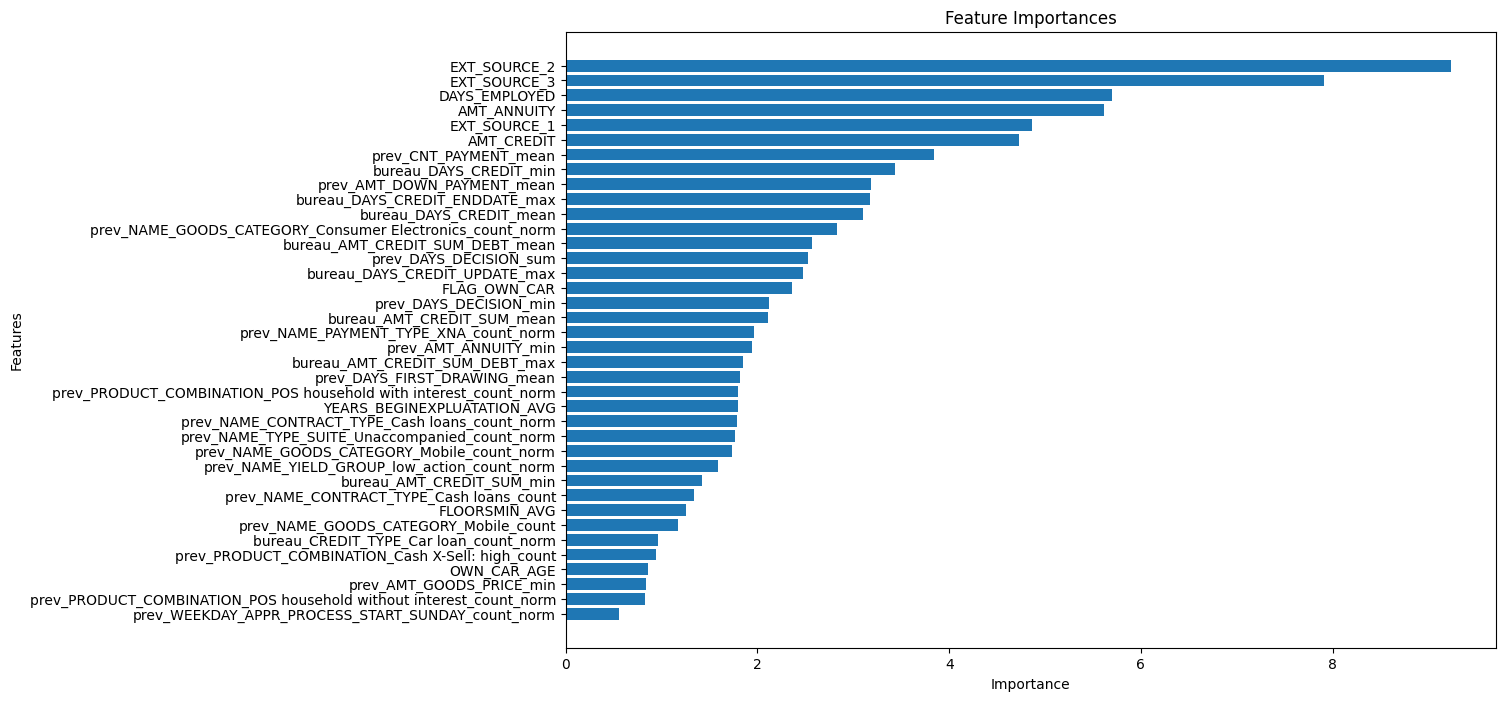

{'learn': {'Accuracy:use_weights=true': 0.9006761886377495,
  'Logloss': 0.3385221574308152,
  'Precision:use_weights=true': 0.8611716439394729,
  'F1:use_weights=true': 0.9058264850390277,
  'Recall:use_weights=true': 0.9553656220322887},
 'validation': {'NormalizedGini:use_weights=true': 0.44857193686117225,
  'Accuracy:use_weights=true': 0.6742023776873993,
  'Logloss': 0.6194345856190254,
  'Precision:use_weights=true': 0.7191572059278845,
  'F1:use_weights=true': 0.6416068970968701,
  'Recall:use_weights=true': 0.6335877862595419,
  'AUC': 0.7242859684305861}}

In [11]:
importance_df_dr = importance_df
features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
train_dropped = train_corrs_removed[importances_filtered.columns].drop(columns=features_to_drop)



while len(importance_df_dr[importance_df_dr["Importance"] <= 0.5]) > 0:
   
    X_dr = train_dropped
    y_dr = train_corrs_removed["TARGET"]
    
    X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_dr, y_dr, 
                                                        random_state=42, 
                                                        test_size=0.2)
    
    # Fit model
    catboost_model.fit(X_train_dr, y_train_dr, eval_set=(X_test_dr, y_test_dr), use_best_model=True)
    feature_importances_dr = catboost_model.get_feature_importance()
    importance_df_dr = create_importance_df(X_train_dr, feature_importances_dr)
    features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
    train_dropped = train_dropped.drop(columns=features_to_drop)
get_feature_importances()
catboost_model.get_best_score()

In [12]:
print(classification_report(y_test, catboost_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      4720
           1       0.12      0.55      0.20       262

    accuracy                           0.76      4982
   macro avg       0.54      0.66      0.53      4982
weighted avg       0.92      0.76      0.83      4982



In [13]:
y_pred = catboost_model.predict_proba(X_test)[:, 1]

wandb.init(
        project=project_name, name=exp_name+"2.1"+"_permutation_auc_weighted_cyclical_catboost"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y_test, y_pred=catboost_model.predict(X_test)),
        "f1_score_weighted": f1_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "precision_weighted": precision_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y_test, y_probas = catboost_model.predict_proba(X_test))
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.76495
f1_score_weighted,0.82732
gini,0.44857
precision_weighted,0.92393
roc_auc_score,0.72429


Видно значительно возросшие f-меру и accuracy при незначительном падении метрики.
#### А что если отстроиться на фичах, очищенных от выбросов предыдущим методом?

In [19]:
outliers_data = pd.read_csv("1_outliers_raw_data")
outliers_data

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANI

Learning rate set to 0.281139
0:	total: 17.4ms	remaining: 1.72s
99:	total: 1.58s	remaining: 0us


Text(0.5, 0, 'Decrease in accuracy score')

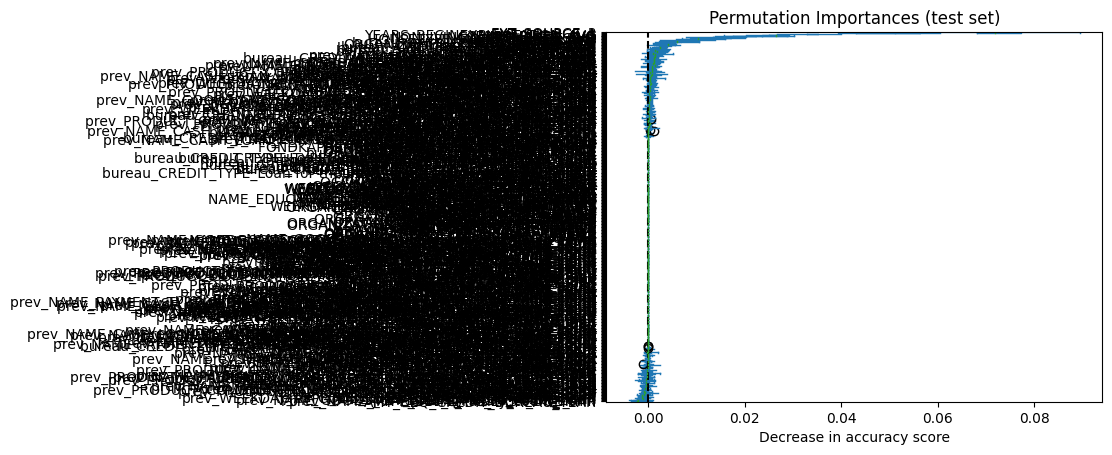

In [20]:
# Создадим классификатор для задачи

catboost_model = CatBoostClassifier(
    iterations=100,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42,
    #min_data_in_leaf=20
    
)

# Создадим отложенную валидацию
X = outliers_data.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = outliers_data["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# фитим алгоритм

catboost_model.fit(X_train, y_train)

# Посчитаем важность фич по перестановкам
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight

weights = compute_sample_weight(class_weight="balanced", y=y_test)

result = permutation_importance(
    catboost_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring="roc_auc", sample_weight = weights
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
#ax.figure.tight_layout()

Text(0.5, 0, 'Decrease in accuracy score')

<Figure size 1600x1000 with 0 Axes>

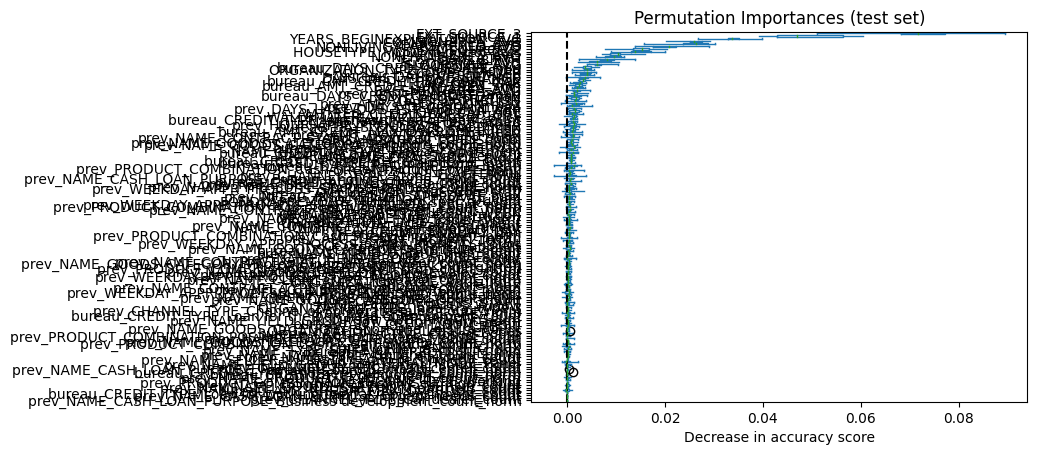

In [21]:
importances_filtered = importances.loc[:, (importances.sum() > 0)]
fig = plt.figure()
fig.set_size_inches(16, 10)
ax = importances_filtered.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
#ax.figure.tight_layout()

Learning rate set to 0.175002
0:	test: 0.7258576	best: 0.7258576 (0)	total: 28.5ms	remaining: 2.82s
99:	test: 0.8638402	best: 0.8681298 (65)	total: 936ms	remaining: 0us

bestTest = 0.8681297821
bestIteration = 65

Shrink model to first 66 iterations.


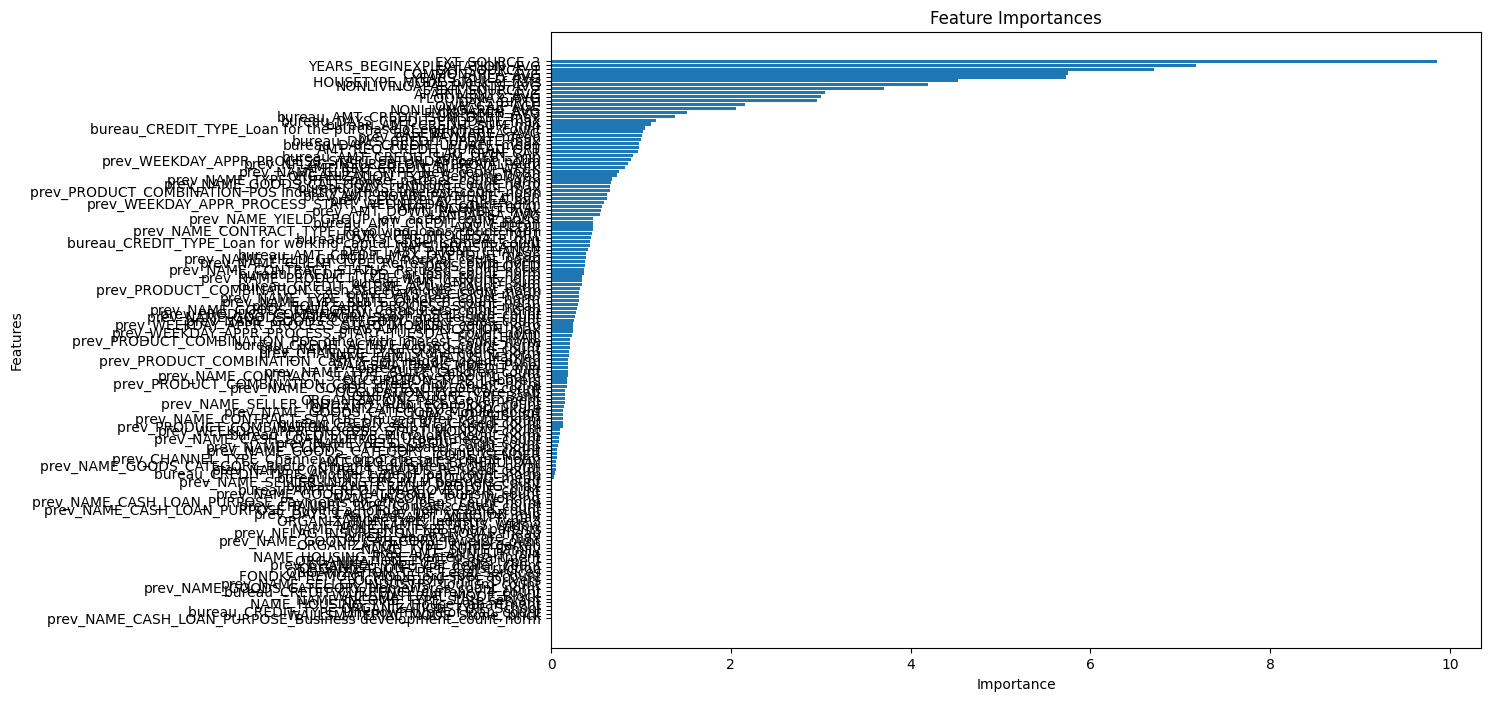

{'learn': {'Accuracy:use_weights=true': 0.9606359470383092,
  'Logloss': 0.2116574380783797,
  'Precision:use_weights=true': 0.935665833914017,
  'F1:use_weights=true': 0.9617325919983695,
  'Recall:use_weights=true': 0.9892933618843683},
 'validation': {'NormalizedGini:use_weights=true': 0.7362595641646488,
  'Accuracy:use_weights=true': 0.7743380436148324,
  'Logloss': 0.48162463164584596,
  'Precision:use_weights=true': 0.8837427444008791,
  'F1:use_weights=true': 0.7608242966307533,
  'Recall:use_weights=true': 0.744,
  'AUC': 0.8681297820823244}}

In [34]:
# Замерим метрики на отобранных таким образом фичах (второй вариант)

X = outliers_data[importances_filtered.columns]
y = outliers_data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)


# Установочный запуск + иницииализация параметров
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)


# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
catboost_model.get_best_score()

In [36]:
perm_full_features = importance_df["Features"]
perm_full_features.to_csv("2_perm_full_features_out.csv", index=False)

In [24]:
y_pred = catboost_model.predict_proba(X_test)[:, 1]

wandb.init(
        project=project_name, name=exp_name+"2.2"+"_permutation_auc_weighted_outliers"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y_test, y_pred=catboost_model.predict(X_test)),
        "f1_score_weighted": f1_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "precision_weighted": precision_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y_test, y_probas = catboost_model.predict_proba(X_test))
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.87009
f1_score_weighted,0.89569
gini,0.73626
precision_weighted,0.93624
roc_auc_score,0.86813


Learning rate set to 0.175002
0:	test: 0.7593535	best: 0.7593535 (0)	total: 7.89ms	remaining: 782ms
99:	test: 0.8601172	best: 0.8659022 (88)	total: 686ms	remaining: 0us

bestTest = 0.8659021792
bestIteration = 88

Shrink model to first 89 iterations.
Learning rate set to 0.175002
0:	test: 0.7163215	best: 0.7163215 (0)	total: 13.4ms	remaining: 1.33s
99:	test: 0.8611429	best: 0.8611429 (99)	total: 703ms	remaining: 0us

bestTest = 0.8611428571
bestIteration = 99

Learning rate set to 0.175002
0:	test: 0.7437453	best: 0.7437453 (0)	total: 7.52ms	remaining: 744ms
99:	test: 0.8671128	best: 0.8671128 (99)	total: 630ms	remaining: 0us

bestTest = 0.8671128329
bestIteration = 99

Learning rate set to 0.175002
0:	test: 0.7814901	best: 0.7814901 (0)	total: 6.73ms	remaining: 667ms
99:	test: 0.8598983	best: 0.8618131 (92)	total: 636ms	remaining: 0us

bestTest = 0.8618130751
bestIteration = 92

Shrink model to first 93 iterations.


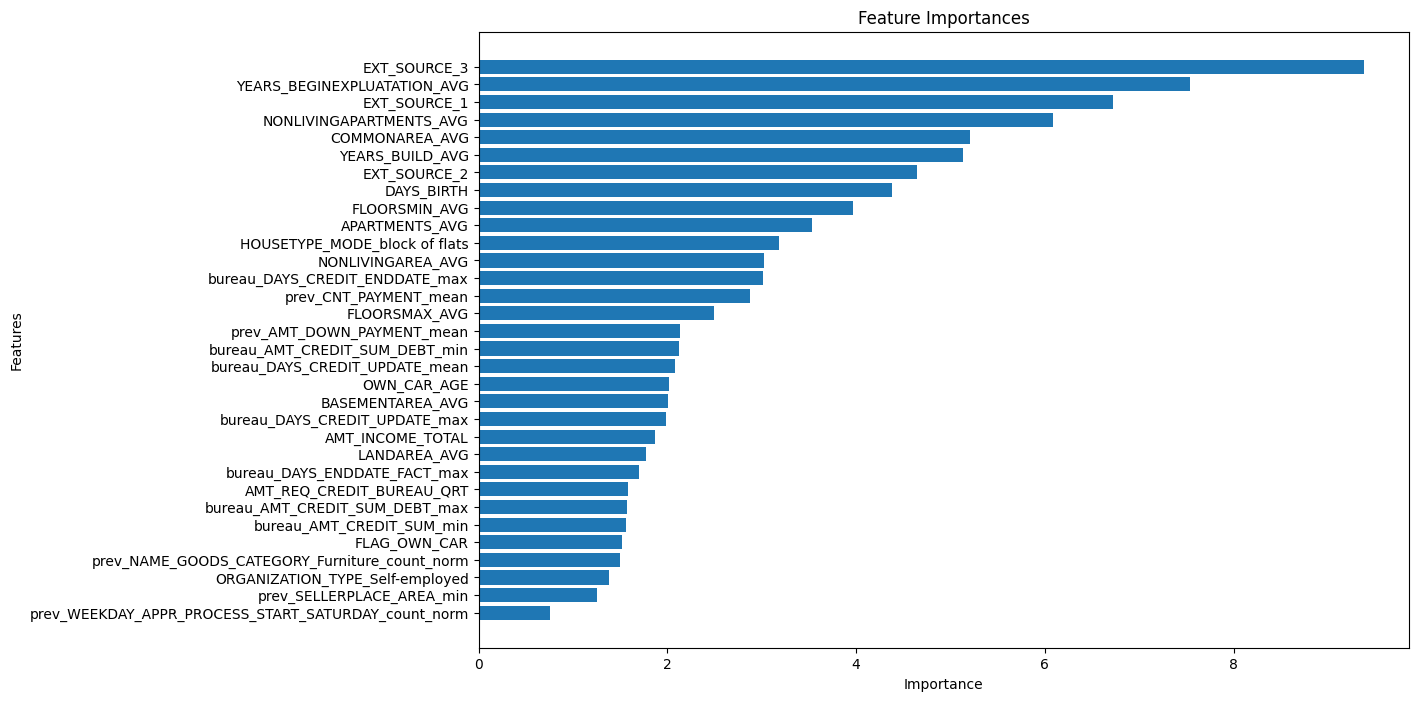

{'learn': {'Accuracy:use_weights=true': 0.9569648737087949,
  'Logloss': 0.20772154981874666,
  'Precision:use_weights=true': 0.9300782526832437,
  'F1:use_weights=true': 0.9582692850391656,
  'Recall:use_weights=true': 0.9882226980728052},
 'validation': {'NormalizedGini:use_weights=true': 0.7236261501210652,
  'Accuracy:use_weights=true': 0.7679501997847981,
  'Logloss': 0.48960992283473265,
  'Precision:use_weights=true': 0.8751129419636029,
  'F1:use_weights=true': 0.7669200076207299,
  'Recall:use_weights=true': 0.744,
  'AUC': 0.8618130750605326}}

In [26]:
importance_df_dr = importance_df
features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
train_dropped = outliers_data[importances_filtered.columns].drop(columns=features_to_drop)



while len(importance_df_dr[importance_df_dr["Importance"] <= 0.5]) > 0:
   
    X_dr = train_dropped
    y_dr = outliers_data["TARGET"]
    
    X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_dr, y_dr, 
                                                        random_state=42, 
                                                        test_size=0.2)
    
    # Fit model
    catboost_model.fit(X_train_dr, y_train_dr, eval_set=(X_test_dr, y_test_dr), use_best_model=True)
    feature_importances_dr = catboost_model.get_feature_importance()
    importance_df_dr = create_importance_df(X_train_dr, feature_importances_dr)
    features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
    train_dropped = train_dropped.drop(columns=features_to_drop)
get_feature_importances()
catboost_model.get_best_score()

In [27]:
y_pred = catboost_model.predict_proba(X_test)[:, 1]

wandb.init(
        project=project_name, name=exp_name+"2.3"+"_permutation_auc_weighted_outliers_CyCB"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y_test, y_pred=catboost_model.predict(X_test)),
        "f1_score_weighted": f1_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "precision_weighted": precision_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y_test, y_probas = catboost_model.predict_proba(X_test))
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.88356
f1_score_weighted,0.90335
gini,0.72363
precision_weighted,0.93268
roc_auc_score,0.86181


### Выводы
Обучение на данных с отобранными выбросами значительно повышает качество итоговой метрики.
Отбрасывание нулевых фич по важности катбуста незначительно отрицательно влияет на метрику, но значительно повышает интерпретируемость и скорость модели.

In [30]:
best_features = importance_df_dr["Features"]
best_features.to_csv("2_best_features_permutation_out.csv", index=False)
train_dropped.to_csv("2_best_features_permutation.csv", index=False)